In [34]:
!git clone https://github.com/francescanaretto/XAI-course_2021

Cloning into 'XAI-course_2021'...
remote: Enumerating objects: 2547, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 2547 (delta 0), reused 2 (delta 0), pack-reused 2540
Receiving objects: 100% (2547/2547), 698.01 MiB | 17.52 MiB/s, done.
Resolving deltas: 100% (283/283), done.
Checking out files: 100% (1945/1945), done.


In [37]:
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
!nvidia-smi

Tue Dec 13 10:41:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    32W /  70W |   1824MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
cd XAI-course_2021/Images

[Errno 2] No such file or directory: './XAI-course_2021/'
/Users/francescobodria/Github/XAI-course_2021/Images


In [1]:
# black box modelling
import torch
import numpy as np
from tqdm.notebook import tqdm
from torch import nn
import warnings
warnings.filterwarnings("ignore")
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from pytorch_lightning.callbacks import TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger
from torchvision.models.resnet import ResNet, BasicBlock
from torchvision import transforms, datasets
device = "cuda" if torch.cuda.is_available() else "cpu"

class pl_resnet18(pl.LightningModule):
    def __init__(self):
        super(pl_resnet18,self).__init__()
        self.model = ResNet(layers=[4,4,4,4],block=BasicBlock, num_classes=2)
        self.lr = 1e-3
        self.loss = nn.CrossEntropyLoss()
    def forward(self, x):
        return self.model.forward(x)
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.forward(x)
        loss = self.loss(logits,y)
        self.log("train_loss", loss, on_epoch=True)
        return loss
    def validation_step(self, valid_batch, batch_idx):
        x, y = valid_batch
        logits = self.forward(x)
        loss = self.loss(logits,y)
        self.log("val_loss", loss, on_epoch=True)
clf_resnet18 = pl_resnet18()

<img src="./images/resnet.jpg" width="80%">

In [2]:
clf_resnet18.load_state_dict(torch.load(f'./models/imagenette_resnet18_v2.pt'))
clf_resnet18.to(device)
clf_resnet18.eval()

pl_resnet18(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [3]:
# # -------- training ----------
# class Data(pl.LightningDataModule):
#     def prepare_data(self):   
#         train_data_dir = './datasets/imagenette/train'  
#         val_data_dir = './Images/datasets/imagenette/val'  
#         transform = transforms.Compose([
#             transforms.ToTensor(),
#             transforms.Resize(256),
#             transforms.CenterCrop(224)])  
#         self.train_data = datasets.ImageFolder(train_data_dir, transform=transform)
#         self.val_data = datasets.ImageFolder(val_data_dir, transform=transform)
#     def train_dataloader(self):
#         return torch.utils.data.DataLoader(self.train_data,batch_size=64,shuffle=True)
#     def val_dataloader(self):
#         return torch.utils.data.DataLoader(self.val_data,batch_size=64,shuffle=True)
# data = Data()
# logger = TensorBoardLogger("NN_logs", name=f"resnet18_imagenette", version=0)
# es = EarlyStopping(monitor="val_loss", mode="min")
# class LitProgressBar(TQDMProgressBar):
#     def init_validation_tqdm(self):
#         bar = tqdm(disable=True)
#         return bar
# bar = LitProgressBar()
# trainer = pl.Trainer(logger=logger, max_epochs=15, callbacks=[es,bar], enable_checkpointing=False, accelerator="gpu")
# trainer.fit(clf_resnet18,data)
# torch.save(clf_resnet18.state_dict(), f'./models/imagenette_resnet18.pt')

In [4]:
train_data_dir = './datasets/imagenette/train'  
val_data_dir = './datasets/imagenette/val'  
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256),
    transforms.CenterCrop(224)])  
train_data = datasets.ImageFolder(train_data_dir, transform=transform)
val_data = datasets.ImageFolder(val_data_dir, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data,batch_size=128,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data,batch_size=128,shuffle=True)

train_preds = []
train_labels = []
val_preds = []
val_labels = []
with torch.no_grad():
    clf_resnet18.eval()
    clf_resnet18.to(device)
    for images, labels in train_loader:
        train_preds.append(clf_resnet18.forward(images.to(device)).argmax(dim=1).cpu().detach().numpy())
        train_labels.append(labels.data.numpy())
    for images, labels in val_loader:
        val_preds.append(clf_resnet18.forward(images.to(device)).argmax(dim=1).cpu().detach().numpy())
        val_labels.append(labels.data.numpy())
train_preds = np.hstack(train_preds)
train_labels = np.hstack(train_labels)
val_preds = np.hstack(val_preds)
val_labels = np.hstack(val_labels)

In [5]:
from sklearn.metrics import accuracy_score

print('Train Accuracy: ', accuracy_score(train_labels, train_preds))
print('Val Accuracy: ', accuracy_score(val_labels, val_preds))

Train Accuracy:  0.7467294610151753
Val Accuracy:  0.7237008871989861


In [6]:
from sklearn.metrics import classification_report

print(classification_report(train_labels, train_preds, target_names=['golf ball','parachute']))
print(classification_report(val_labels, val_preds, target_names=['golf ball','parachute']))

              precision    recall  f1-score   support

   golf ball       0.98      0.50      0.66       951
   parachute       0.67      0.99      0.80       960

    accuracy                           0.75      1911
   macro avg       0.82      0.75      0.73      1911
weighted avg       0.82      0.75      0.73      1911

              precision    recall  f1-score   support

   golf ball       0.95      0.48      0.64       399
   parachute       0.65      0.97      0.78       390

    accuracy                           0.72       789
   macro avg       0.80      0.73      0.71       789
weighted avg       0.80      0.72      0.71       789



<img src="./images/precision_recall.png" width="420">

## Hint

In [7]:
test_images = ['./datasets/imagenette/val/golf_ball/n03445777_551.JPEG',
'./datasets/imagenette/train/golf_ball/n03445777_2039.JPEG',
'./datasets/imagenette/train/golf_ball/n03445777_237.JPEG']

# Black Box Analysis

In [ ]:
path = test_images[1]

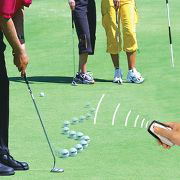

In [ ]:
from PIL import Image
image = Image.open(path)
image

prediction:  1
probability:  0.5725374


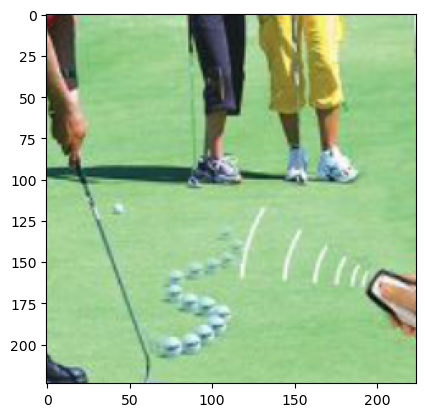

In [ ]:
import matplotlib.pyplot as plt

def preprocess(image):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224)])
    image = transform(torch.tensor(image/255).permute(2,0,1)).float()
    return image

image = plt.imread(path)
image = preprocess(image)
plt.imshow(image.permute(1,2,0))
image = image.unsqueeze(0)

with torch.no_grad():
    pred = int(clf_resnet18.forward(image.to(device)).cpu().detach().numpy().argmax(axis=1))
    pred_proba = torch.nn.functional.softmax(clf_resnet18.forward(image.to(device)),dim=1)[0,pred].numpy()

print('prediction: ', pred)
print('probability: ', pred_proba)

# XAI Analysis